In [1]:
import numpy as np
from scipy import stats
import random
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
# COLOR = 'white'
# mpl.rcParams['text.color'] = COLOR
# mpl.rcParams['axes.labelcolor'] = COLOR
# mpl.rcParams['xtick.color'] = COLOR
# mpl.rcParams['ytick.color'] = COLOR

# Algorithm for generating money

$n_0$ people draw money from a money pool containing $M_0$ dollars:

Let $X_n$ be the remaining money in the pool after the $n$-th draw
($X \in [0, M_0]$, $0$-th draw means no draw has occurred), and uniform
random variable $K \sim \mathcal{U}(0, 1)$.

Let's define the algorithm to generate the money of the $i$-th draw:

$ M_i = $\begin{cases}
\max(0.01, K \frac{X_i}{n_c(i)}) & i=1,2,3,\dots n_0 - 1 \\
X_i & i = n_0 \\
\end{cases}

where $n_c(i)$ is the current number of players who haven't drawn, so
$n_c(i) = n_0 - i + 1$.

So $ M_i = $\begin{cases}
\max(0.01, K \frac{X_i}{n_0 - i + 1}) & i=1,2,3,\dots n_0 - 1 \\
X_i & i = n_0 \\
\end{cases}

In [2]:
class RedBag:
    def __init__(self, n_bags: int, money: float):
        self.n_remain = self.n_bags = n_bags
        self.money_remain = self.money = money

    def get_money(self):
        """
        Get money from this red bag
        :return: how much money of a new red bag
        """
        assert self.money_remain >= 0
        if self.n_remain ==  1:
            money = self.money_remain
            self.money_remain = 0
            self.n_remain = 0
        else:
            min_ = 0.01
            max_ = 2 * self.money_remain / self.n_remain
            money = np.random.uniform(0, 1.0, 1)[0] * max_
            money = max(min_, money)
            self.n_remain -= 1
            self.money_remain -= money
        return money

In [3]:
def sim_trial(n_bags: int, money: float):
    rb = RedBag(n_bags, money)
    trials = [rb.get_money() for _ in range(n_bags)]
    return trials

In [4]:
n_trials = 200
n_players = 10
money = 66.0
np.random.seed(1024)
data = np.asarray([sim_trial(n_players, money) for i in range(n_trials)]).T
data.shape

(10, 200)

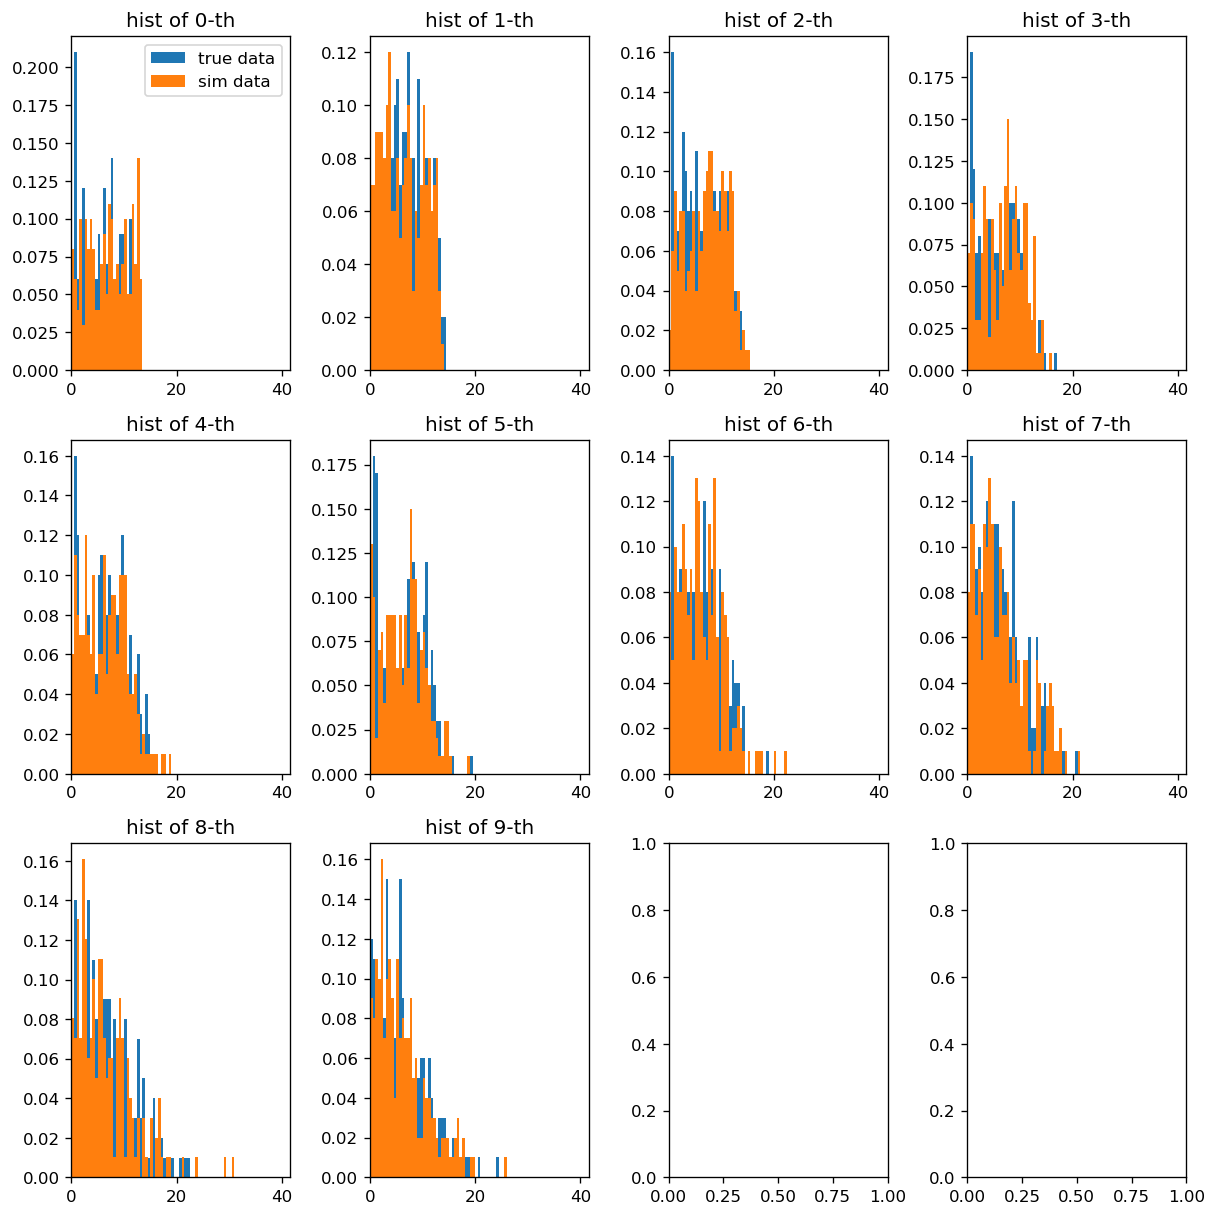

In [5]:
def plot_hist_for_players(data1: np.ndarray, data2: np.ndarray,
                          bin_size: float = 0.5):
    fig, axs = plt.subplots(3, 4)
    fig.set_size_inches(10.24, 10.24)
    axs = axs.flat
    xlim = max(np.max(data1), np.max(data2))
    bins = np.arange(0.0, xlim + 0.1, step=bin_size)
    for i in range(10):
        axs[i].hist(data1[i,], bins=bins, density=True, label="true data")
        axs[i].hist(data2[i,], bins=bins, density=True, label="sim data")
        axs[i].set_title('hist of {}-th'.format(i))
        axs[i].set_xlim([0, xlim])
    axs[0].legend()
    fig.tight_layout()
    plt.show()

data_true = np.loadtxt('trials.csv')
plot_hist_for_players(data_true, data)

In [6]:
def get_dist(data: np.ndarray, bin_size: float = 0.5):
    xlim = np.max(data)
    bins = np.arange(0.0, xlim + 0.1, step=bin_size)
    histogram = [np.histogram(data[i,], bins) for i in range(10)]
    hist = np.asarray([h[0] for h in histogram])
    dist = hist / data.shape[1]
    return dist, bins

$H_0$: Our algorithm of generating money create the same distribution as
the one that the experiment data is sampled from.

So we reject $H_0$ if $p < 1\% $, where $p$
is obtained by calculating Kolmogorov-Smirnov statistic on 2 samples data.

In [7]:
sim_dists, sim_bins = get_dist(data)
ks_stats = [stats.ks_2samp(data_true[i, ][data_true[i, ] != 0],
                           data[i, ][data[i, ] != 0])
            for i in range(data_true.shape[0])]
ks_stats = np.asarray(ks_stats)

md_str = """
|order| p |reject?|
|-----|---|-------|
|0    |{0:02}%|  {10}|
|1    |{1:02}%|  {11}|
|2    |{2:02}%|  {12}|
|3    |{3:02}%|  {13}|
|4    |{4:02}%|  {14}|
|5    |{5:02}%|  {15}|
|6    |{6:02}%|  {16}|
|7    |{7:02}%|  {17}|
|8    |{8:02}%|  {18}|
|9    |{9:02}%|  {19}|
"""

ps = (ks_stats[:, 1] * 100).astype(int)
md_str = md_str.format(*ps, *(ps < 1))
# Markdown(md_str)
print(md_str)



|order| p |reject?|
|-----|---|-------|
|0    |62%|  False|
|1    |06%|  False|
|2    |05%|  False|
|3    |39%|  False|
|4    |98%|  False|
|5    |62%|  False|
|6    |54%|  False|
|7    |46%|  False|
|8    |08%|  False|
|9    |99%|  False|

